This is customization of work https://github.com/deepak112/Keras-SRGAN
Here Super Resolution GAN (SRGAN) was trained on Labeled faces in the wild dataset http://vis-www.cs.umass.edu/lfw/
The main goal of this work is to get neural network (generator), that takes input image if face with low resolution (32x32) and outputs high resolution image (128x128). It can be used as support tool in face recognnition task.

In [2]:
import matplotlib.pyplot as plt

from keras.models import load_model
import os
import numpy as np
import keras.backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras import regularizers
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras.callbacks import ModelCheckpoint
from six.moves import cPickle as pickle
from keras.utils.np_utils import to_categorical
import keras.backend as K
from six.moves import cPickle as pickle


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras import regularizers
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras.callbacks import ModelCheckpoint

import numpy as np
from keras.utils.np_utils import to_categorical

import itertools
import keras
from keras.datasets import mnist

from keras.layers import Input, Dense, Add, Activation
from keras.models import Model

        
from keras.layers import Input, Dense, Add, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Conv1D, MaxPooling2D

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from keras.models import load_model

import skimage
import glob
import cv2

%matplotlib inline 

Using TensorFlow backend.
/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aevda

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11281531111000153049
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7913891431
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3679935587669907793
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [4]:
from Network import Generator, Discriminator

import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras.applications.vgg19 import VGG19
from keras.layers.convolutional import UpSampling2D
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
import keras
import keras.backend as K
from keras.layers import Lambda, Input
import tensorflow as tf
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from scipy.misc import imresize
import os

np.random.seed(10)
image_shape = (128,128,3)

def vgg_loss(y_true, y_pred):
    
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan


def load_path(path):
    directories = []
    if os.path.isdir(path):
        directories.append(path)
    for elem in os.listdir(path):
        if os.path.isdir(os.path.join(path,elem)):
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    return directories
    
def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    for d in dirs:
        for f in os.listdir(d): 
            if f.endswith(ext):
                image = data.imread(os.path.join(d,f))
                if len(image.shape) > 2:
                    files.append(image)
                    file_names.append(os.path.join(d,f))
                count = count + 1
    return files     
            
def load_data_from_dirs_resize(dirs, ext, size):
    files = []
    file_names = []
    count = 0
    for d in dirs:
        for f in os.listdir(d): 
            if f.endswith(ext):
                files.append(resize(data.imread(os.path.join(d,f)), size))
                file_names.append(os.path.join(d,f))
                count = count + 1
    return files     
                        
          
def load_data(directory, ext):

    files = load_data_from_dirs(load_path(directory), ext)
    return files


files = load_data("/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/faces_hr", ".jpg") 
x_train = files[:2500]
x_test = files[2500:3000]

print("data loaded")


def hr_images(images):
    images_hr = array(images)
    return images_hr

def lr_images(images_real , downscale):
    
    images = []
    for img in  range(len(images_real)):
        images.append(imresize(images_real[img], [images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale], interp='bicubic', mode=None))
    images_lr = array(images)
    return images_lr

def preprocess_HR(x):
    return np.divide(x.astype(np.float32), 127.5) - np.ones_like(x,dtype=np.float32)


def deprocess_HR(x):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8) 


def preprocess_LR(x):
    return np.divide(x.astype(np.float32), 255.)


def deprocess_LR(x):
    x = np.clip(x*255, 0, 255)
    return x

def normalize(input_data):

    return (input_data.astype(np.float32) - 127.5)/127.5 
    
def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8) 

def deprocess_LRS(x):
    x = np.clip(x*255, 0, 255)
    return x.astype(np.uint8)

x_train_hr = hr_images(x_train)
x_train_hr = normalize(x_train_hr)

x_train_lr = lr_images(x_train, 4) # downscale factor 
x_train_lr = normalize(x_train_lr)


x_test_hr = hr_images(x_test)
x_test_hr = normalize(x_test_hr)

x_test_lr = lr_images(x_test, 4) # downscale factor 
x_test_lr = normalize(x_test_lr)

print("data processed")
print('x_test_lr shape = ', x_test_lr.shape)
print('x_test_hr shape = ', x_test_hr.shape)
print('-------------------------------------')
print('x_train_lr shape = ', x_train_lr.shape)
print('x_train_hr shape = ', x_train_hr.shape)

def plot_generated_images(epoch,generator, examples=3 , dim=(1, 3), figsize=(15, 5)):
    
    rand_nums = np.random.randint(0, x_test_hr.shape[0], size=examples)
    image_batch_hr = denormalize(x_test_hr[rand_nums])
    image_batch_lr = x_test_lr[rand_nums]
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    #generated_image = deprocess_HR(generator.predict(image_batch_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[1], interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[1], interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[1], interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/gan_images/gan_generated_image_epoch_32_%d.png' % epoch)
    

def train(epochs=1, batch_size=8):
    
    downscale_factor = 4
    
    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()
    
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    generator.compile(loss=vgg_loss, optimizer=adam)
    discriminator.compile(loss="binary_crossentropy", optimizer=adam)
        
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, 3)
    gan = get_gan_network(discriminator, shape, generator, adam)
    print('batch_count=',batch_count)
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batch_count):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)
            
            #print('imgs_generated')
            
            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            #print('Real_and_fake_Y_generated')
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            #d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            print('losses_cal')
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
        print("Loss HR , Loss LR, Loss GAN")
        print(d_loss_real, d_loss_fake, loss_gan)
        
        with open("logger.txt", "a") as myfile:
            myfile.write(str('Loss HR='))
            myfile.write(str(d_loss_real))
            myfile.write(str('__'))
            myfile.write(str('Loss LR='))
            myfile.write(str(d_loss_fake))
            myfile.write(str('__'))
            myfile.write(str('Loss GAN='))
            myfile.write(str(loss_gan))
            myfile.write('\n')
        
        
        if e == 1 or e % 5 == 0:
            plot_generated_images(e, generator)
        if e % 10 == 0:
            generator.save('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/saved_models/gen_model_32_%d.h5' % e)
            discriminator.save('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/saved_models/dis_model_32_%d.h5' % e)
            gan.save('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/saved_models/gan_model_32_%d.h5' % e)

#train(20000,4)




data loaded


/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


data processed
x_test_lr shape =  (500, 32, 32, 3)
x_test_hr shape =  (500, 128, 128, 3)
-------------------------------------
x_train_lr shape =  (2500, 32, 32, 3)
x_train_hr shape =  (2500, 128, 128, 3)


In [5]:
################ Training ################
train(150,4)

batch_count= 625
--------------- Epoch 1 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_c

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3894381 0.3727853 [0.017206946, 0.0

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.302738 0.40556324 [0.015578061, 0.013685337, 1.8927244]
--------------- Epoch 14 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
loss

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.31290358 0.27831796 [0.010859219, 0.008785228, 2.0739908]
--------------- Epoch 21 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
lo

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.34867287 0.28649586 [0.008770091, 0.006810495, 1.9595957]
--------------- Epoch 28 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
lo

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.24332327 0.36237672 [0.007363244, 0.0061051436, 1.2581]
--------------- Epoch 35 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
loss

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3095786 0.2993744 [0.008410948, 0.0061760442, 2.2349043]
--------------- Epoch 

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3397424 0.22949111 [0.008929176, 0.0066369837, 2.2921925]
--------------- Epoch 55 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
lo

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.40764186 0.42836118 [0.0063881692, 0.0041788234, 2.2093458]
--------------- Epoch 62 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal


losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3084788 0.30629557 [0.007920048, 0.005894266, 2.0257823]
--------------- Epoch 69 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
los

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.23490474 0.23375684 [0.008218251, 0.005887438, 2.3308134]
--------------- Epoch 76 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
lo

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.38051325 0.23817383 [0.008262939, 0.005880595, 2.3823435]
--------------- Epoch 83 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
lo

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.42196578 0.25187385 [0.0064582126, 0.004355212

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--------------- Epoch 101 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
l

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.41619593 0.28

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.34858954 0.370375 [0.0062341876, 0.0041070683, 2.1271195]
--------------- Epoch 114 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
l

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3028987 0.3160597 [0.005953935, 0.0038885197, 2.0654151]
--------------- Epoch 121 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
lo

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.39462048 0.36353326 [0.0058542145, 0.0037606475, 2.0935671]
--------------- Epoch 128 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3524981 0.352939 [0.005038374, 0.0029968699, 2.041504]
--------------- Epoch 135 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
loss

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.3146286 0.4167322 [0.005733029, 0.003691522, 2.041507]
--------------- Epoch 142 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
loss

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
Loss HR , Loss LR, Loss GAN
0.25075683 0.3854189 [0.005873258, 0.0035744936, 2.2987647]
--------------- Epoch 149 ---------------
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
l

losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal
losses_cal

In [186]:
# Preparing Faces Dataset 

In [10]:
import glob

In [6]:
# Making dataset with faces

import PIL
path_faces = glob.glob('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/lfw/*/*.jpg')
faces = np.random.choice(path_faces, size = 3000)

num = 0
for face in faces:
    im = PIL.Image.open(face)
    im = im.resize((128,128), resample= PIL.Image.LANCZOS)
    im.save('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/faces_hr/' + str(num) + '.jpg')
    num = num +1

In [ ]:
def plot_generated_images_test(generator, examples=3 , dim=(1, 3), figsize=(15, 5)):
    
    rand_nums = np.random.randint(0, x_test_hr.shape[0], size=examples)
    image_batch_hr = denormalize(x_test_hr[rand_nums])
    image_batch_lr = x_test_lr[rand_nums]
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    #generated_image = deprocess_HR(generator.predict(image_batch_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[1], interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[1], interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[1], interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/gan_images/gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
x_test_hr = hr_images(x_test)
x_test_hr = normalize(x_test_hr)

In [5]:
generator_30 = load_model('/media/aevdakimov/HDisk/Arthur/Keras-SRGAN-master/saved_models/gen_model_32_150.h5',
                         custom_objects={'vgg_loss':vgg_loss} )

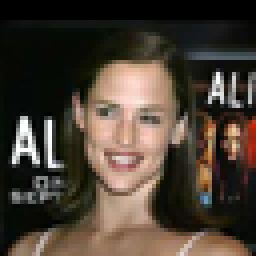

In [98]:
PIL.Image.fromarray(denormalize(x_test_lr[5])).resize((128,128))

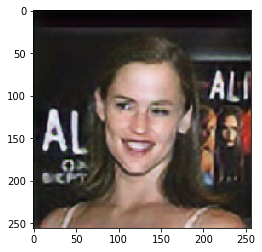

In [21]:
plt.imshow(np.reshape(generated_image, (128,128,3)))

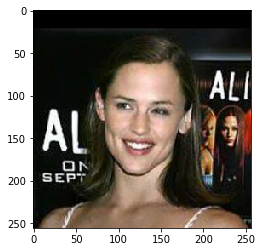

In [36]:
plt.imshow(np.reshape(denormalize(x_test_hr[5]), (128,128,3)))